In [1]:
%pip install pandas scikit-learn numpy seaborn matplotlib

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
titanic_df = pd.read_csv("train.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic_df.shape

(891, 12)

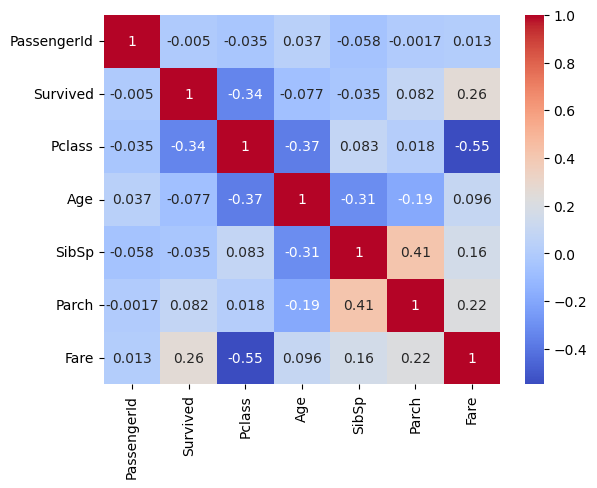

In [6]:
numerical_df = titanic_df.select_dtypes(include=[np.number])

sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [7]:
#


from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(titanic_df, titanic_df["Survived"]):
    train_set = titanic_df.loc[train_index]
    test_set = titanic_df.loc[test_index]

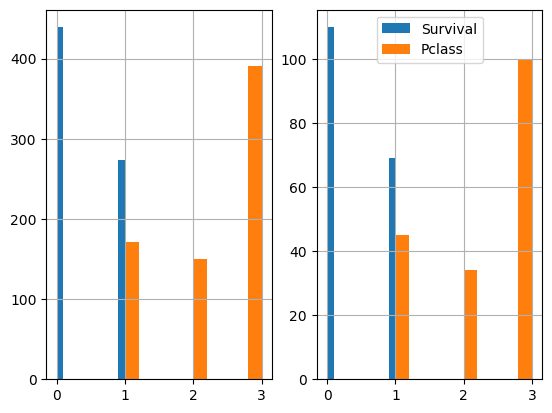

In [8]:
plt.subplot(1,2,1)
train_set["Survived"].hist(label="Survival")
train_set["Pclass"].hist(label="Pclass")
plt.subplot(1,2,2)
test_set["Survived"].hist(label="Survival")
test_set["Pclass"].hist(label="Pclass")
plt.legend()
plt.show()

In [9]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          575 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        160 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 58.4+ KB


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="median")
        X["Age"] = imputer.fit_transform(X[["Age"]])
        return X

In [11]:
from sklearn.preprocessing import OneHotEncoder

class SexEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[["Embarked"]]).toarray()

        column_names = ["C","S","Q","N"]

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        column_names = ["Female","Male"]

        for i in range(len(column_names)):
            X[column_names[i]] =matrix.T[i]
        
        return X

In [12]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(["PassengerId","Name","Ticket","Cabin","Sex","N"], axis=1, errors="ignore")

In [13]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("age imputer", AgeImputer()),("feature encoder",SexEncoder()),("feature dropper",FeatureDropper())])
train_set = pipeline.fit_transform(train_set)

In [14]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Age       712 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  710 non-null    object 
 7   C         712 non-null    float64
 8   S         712 non-null    float64
 9   Q         712 non-null    float64
 10  Female    712 non-null    float64
 11  Male      712 non-null    float64
dtypes: float64(7), int64(4), object(1)
memory usage: 69.5+ KB


### Training and evualating our models

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = train_set.drop(["Survived","Embarked"], axis=1)
y = train_set["Survived"]

X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

dtree = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 3, 4]
}

# Perform grid search
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)

final_dtree = grid_search.best_estimator_

In [18]:
final_dtree

RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=200)

In [19]:
test_set = pipeline.fit_transform(test_set)
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 565 to 637
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  179 non-null    int64  
 1   Pclass    179 non-null    int64  
 2   Age       179 non-null    float64
 3   SibSp     179 non-null    int64  
 4   Parch     179 non-null    int64  
 5   Fare      179 non-null    float64
 6   Embarked  179 non-null    object 
 7   C         179 non-null    float64
 8   S         179 non-null    float64
 9   Q         179 non-null    float64
 10  Female    179 non-null    float64
 11  Male      179 non-null    float64
dtypes: float64(7), int64(4), object(1)
memory usage: 17.5+ KB


In [20]:
X_test_data = test_set.drop(["Survived","Embarked"], axis=1) 
y_test_data = test_set["Survived"]

scaler = StandardScaler()
X_test_data = scaler.fit_transform(X_test_data)
y_test_data = y_test_data.to_numpy()

In [21]:
final_dtree.score(X_test_data, y_test_data)    

0.6703910614525139

In [22]:
final_titanic_df = pipeline.fit_transform(titanic_df)

In [23]:
X_final_data = final_titanic_df.drop(["Survived","Embarked"], axis=1)
y_final_data = final_titanic_df["Survived"]

X_data_final = scaler.fit_transform(X_final_data)
y_data_final = y_final_data.to_numpy()


In [24]:
prod_dtree = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 3, 4]
}

grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 100, 200, 500]},
             return_train_score=True, scoring='accuracy')

In [25]:
prod_final_dtree = grid_search.best_estimator_
prod_final_dtree

RandomForestClassifier(max_depth=5, min_samples_split=4)

In [26]:
titanic_test_df = pd.read_csv("test.csv")
titanic_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 27.8+ KB


In [27]:
final_titanic_test_df = pipeline.fit_transform(titanic_test_df)
final_titanic_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Age       418 non-null    float64
 2   SibSp     418 non-null    int64  
 3   Parch     418 non-null    int64  
 4   Fare      417 non-null    float64
 5   Embarked  418 non-null    object 
 6   C         418 non-null    float64
 7   S         418 non-null    float64
 8   Q         418 non-null    float64
 9   Female    418 non-null    float64
 10  Male      418 non-null    float64
dtypes: float64(7), int64(3), object(1)
memory usage: 34.4+ KB


In [29]:
X_final_test = final_titanic_test_df
X_final_test = X_final_test.ffill()

X_final_test_numeric = X_final_test.select_dtypes(include=[np.number])

scaler = StandardScaler()
X_final_test_scaled = scaler.fit_transform(X_final_test_numeric)

In [30]:
preds = prod_final_dtree.predict(X_final_test_scaled)
preds

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [31]:
final_df = pd.DataFrame(titanic_test_df["PassengerId"])
final_df["Survived"] = preds
final_df.to_csv("predictions.csv", index=False)